# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [1]:
import os
!pip install gym==0.14

     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
      --------------------------------------- 0.0/1.6 MB 1.3 MB/s eta 0:00:02
     - -------------------------------------- 0.1/1.6 MB 787.7 kB/s eta 0:00:02
     --- ------------------------------------ 0.2/1.6 MB 1.1 MB/s eta 0:00:02
     --- ------------------------------------ 0.2/1.6 MB 1.1 MB/s eta 0:00:02
     ----- ---------------------------------- 0.2/1.6 MB 1.0 MB/s eta 0:00:02
     ------- -------------------------------- 0.3/1.6 MB 1.0 MB/s eta 0:00:02
     ---------- ----------------------------- 0.4/1.6 MB 1.3 MB/s eta 0:00:01
     ------------- -------------------------- 0.5/1.6 MB 1.4 MB/s eta 0:00:01
     --------------- ------------------------ 0.6/1.6 MB 1.6 MB/s eta 0:00:01
     ------------------ --------------------- 0.7/1.6 MB 1.7 MB/s eta 0:00:01
     ------------------ --------------------- 0.7/1.6 MB 1.7 MB/s eta 0:00:01
     ------------------------- -------------- 1.0/1.6 MB 1.8 MB/s eta

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2023.6.0 requires cloudpickle>=1.5.0, but you have cloudpickle 1.2.2 which is incompatible.
distributed 2023.6.0 requires cloudpickle>=1.5.0, but you have cloudpickle 1.2.2 which is incompatible.


In [7]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v2")
env.reset()
env.render('human')

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [8]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


# Initialize policy (0.5pts)

In [9]:
def default_policy(n_states, n_actions):
    return np.ones((n_states, n_actions)) / n_actions


policy = default_policy(n_states, n_actions)
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
print("Ok!")

Ok!


# Play the game (0.5pts)

Just like before, but we also record all states and actions we took.

In [50]:
def generate_session(policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.
    
    state = env.reset()
    
    for t in range(t_max):
        states.append(state)
        action = np.random.choice(range(n_actions), p = policy[state])
        
        x = env.step(action)
        new_state = x[0]
        reward = x[1]
        done = x[2]
        
        #Record state, action and add up reward to states, actions and total_reward accordingly. 
        #add state
        #add action
        actions.append(action)
        #add reward
        total_reward += reward
        
        state = new_state
        if done:
            break
    return states, actions, total_reward
        

In [51]:
np.float = float    

In [52]:
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float]
print("OK!")

OK!


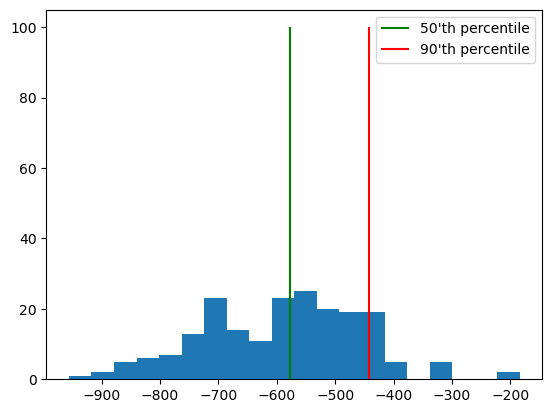

In [53]:
#let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20);
plt.vlines([np.percentile(sample_rewards,50)],[0],[100],label="50'th percentile",color='green')
plt.vlines([np.percentile(sample_rewards,90)],[0],[100],label="90'th percentile",color='red')
plt.legend()

### Crossentropy method steps (1pts)

In [54]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """ 
    
    rewards_batch = np.array(rewards_batch)
    
    n_session = len(states_batch)
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    ind = np.arange(n_session)
    
    ind = ind[rewards_batch[ind] >= reward_threshold]
    
    print(ind)
    
    elite_states = [states_batch[i] for i in ind]
    elite_actions = [actions_batch[i] for i in ind]
    
    if(len(np.array(states_batch[0]).shape) == 1):
        elite_states = np.hstack(elite_states)
    else:
        elite_states = np.vstack(elite_states)
    elite_actions = np.hstack(elite_actions)
    
    return elite_states,elite_actions
    

In [55]:
states_batch = [
    np.array([1,2,3]),   #game1
    np.array([4,2,0,2]), #game2
    np.array([3,1])      #game3
]

actions_batch = [
    np.array([0,2,4]),   #game1
    np.array([3,2,0,1]), #game2
    np.array([3,3])      #game3
]
rewards_batch = np.array([
    3,         #game1
    4,         #game2
    5,         #game3
])

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_40 = select_elites(states_batch,actions_batch,rewards_batch,percentile=30)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

[0 1 2]
[1 2]
[2]
[2]
Ok!


In [56]:
def update_policy(elite_states, elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to
    
    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
    
    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions
    
    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions
    
    """
    
    n_elite = len(elite_states)
    
    new_policy = np.zeros([n_states,n_actions])
    
    for i in range(n_elite):
        new_policy[elite_states[i]][elite_actions[i]] += 1
    
    #<Your code here: update probabilities for actions given elite states & actions>
    #Don't forget to set 1/n_actions for all actions in unvisited states.
    
    for i in range(n_states):
        s = sum(new_policy[i])
        if s == 0:
            new_policy[i] = np.ones(n_actions) / n_actions
        else:
            new_policy[i] /= s
            
            
    return new_policy

In [57]:

elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
print(new_policy[:4,:5])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

[[1.         0.         0.         0.         0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.33333333 0.66666667 0.         0.        ]
 [0.         0.         0.         0.5        0.5       ]]
Ok!


# Training loop (1pts)
Generate sessions, select N best and fit to those.

In [58]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def show_progress(rewards_batch, log, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [59]:
policy = default_policy(n_states, n_actions)

mean reward = -99.010, threshold=7.000


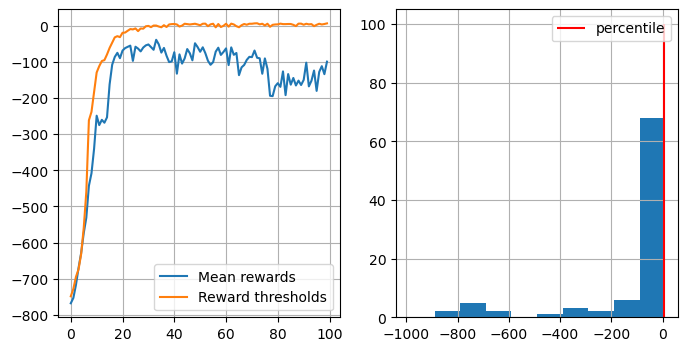

In [60]:
n_sessions = 100  #sample this many sessions
percentile = 70  #take this percent of session with highest rewards
learning_rate = 0.4  #add this thing to all counts for stability

log = []

for i in range(100):
    
    %time sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    states_batch,actions_batch,rewards_batch = zip(*sessions)
    
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=50)
    
    new_policy = update_policy(elite_states,elite_actions)
    
    policy = policy * (1 - learning_rate) + learning_rate * new_policy
    
    #display results on chart
    show_progress(rewards_batch,log)

# Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples. Show all precentiles on one graph and all n_samples on another
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


In [16]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v3", render_mode="ansi")
env.reset()
n_states = env.observation_space.n
n_actions = env.action_space.n
policy = 1/6. * np.ones([n_states, n_actions])
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float]
policy = np.ones([n_states,n_actions])/n_actions 
stepCounter = 100

C:\Users\vinik\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


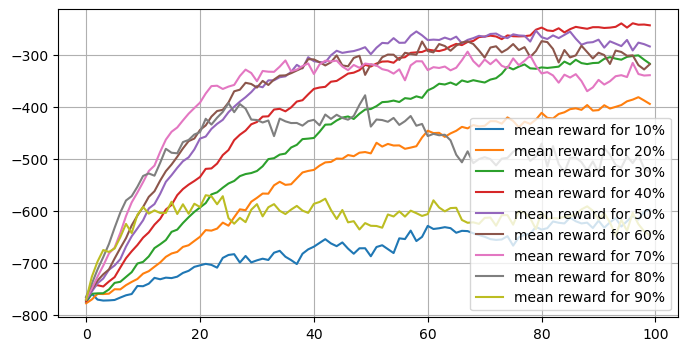

In [17]:
n_sessions = 500  #sample this many sessions
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90]  #take this percent of session with highest rewards
learning_rate = 0.4  #add this thing to all counts for stability

log = []
mean = []

def show_progress_percentile(mean, p):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    clear_output(True)
    plt.figure(figsize=[8,4])
    for i in range(len(p)):
        plt.plot(mean[i], label="mean reward for " + str(p[i]) + "%")
    plt.legend()
    plt.grid()
    
    plt.show()

p = []
    
for percentile in percentiles:
    curMean = []
    policy = np.ones([n_states,n_actions])/n_actions
    for i in range(stepCounter): #change

        %time sessions = [generate_session(policy) for _ in range(n_sessions)]

        states_batch,actions_batch,rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch, actions_batch,np.array(rewards_batch),percentile=percentile)
        #set new policy
        new_policy = update_policy(elite_states,elite_actions)
        #update policy
        policy = policy * (1 - learning_rate) + learning_rate * new_policy
        #add mean value
        curMean.append(np.mean(rewards_batch))
        
#         clear_output(True)
    mean.append(curMean)
    p.append(percentile)
    #display results on chart
    show_progress_percentile(mean, p)

# How do different percentiles affect training efficiency?

In [18]:
# Describe your observations

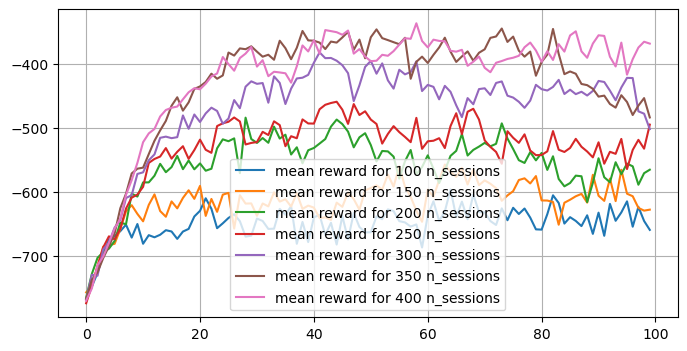

In [19]:
n_sessions_ar = [100, 150, 200, 250, 300, 350, 400]  #sample this many sessions
perc = 70  #take this percent of session with highest rewards
learning_rate = 0.4  #add this thing to all counts for stability

def show_progress_n(mean, n):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    clear_output(True)
    plt.figure(figsize=[8,4])
    for i in range(len(n)):
        plt.plot(mean[i], label="mean reward for " + str(n[i]) + " n_sessions")
    plt.legend()
    plt.grid()
    
    plt.show()

n = []

mean = []
for n_sessions in n_sessions_ar:
    curMean = []
    policy = np.ones([n_states,n_actions])/n_actions
    for i in range(stepCounter):

        %time sessions = [generate_session(policy) for _ in range(n_sessions)]

        states_batch,actions_batch,rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch, actions_batch,np.array(rewards_batch),percentile=perc)
        #set new policy
        new_policy = update_policy(elite_states,elite_actions)
        #update policy
        policy = policy * (1 - learning_rate) + learning_rate * new_policy
        #add mean value
        curMean.append(np.mean(rewards_batch))
        
    mean.append(curMean)
    n.append(n_sessions)
    
    show_progress_n(mean, n)

# Stabilize positive rewards by averaging policy across 10 games (2 pts)

In [20]:
def generate_session(policy, t_max=10**4, cnt=10):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.
    
    state = env.reset()[0]
    
    for _ in range(cnt):
        state = env.reset()[0]
        for t in range(t_max):
            action = np.random.choice(range(n_actions), p = policy[state])

            new_state, reward, done, _, info = env.step(action)

            done = done or _

            #Record state, action and add up reward to states, actions and total_reward accordingly. 
            #add state
            states.append(new_state)
            #add action
            actions.append(action)
            #add reward
            total_reward += reward

            state = new_state
            if done:
                break
    return states, actions, total_reward / cnt

mean reward = -384.501, threshold=-355.340


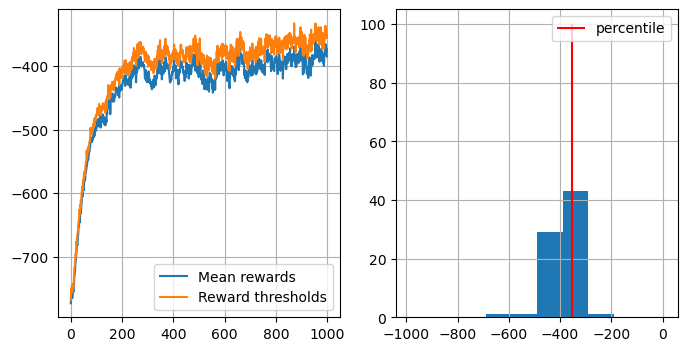

In [21]:
n_sessions = 75  #sample this many sessions
percentile = 70  #take this percent of session with highest rewards
learning_rate = 0.2  #add this thing to all counts for stability

log = []
mean = []
policy = np.ones([n_states,n_actions])/n_actions
for i in range(1000):

    %time sessions = [generate_session(policy) for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, np.array(rewards_batch), percentile=percentile)

    new_policy = update_policy(elite_states,elite_actions)

    policy = policy * (1 - learning_rate) + learning_rate * new_policy

    show_progress(rewards_batch,log)
    
    if(np.mean(rewards_batch) > 7):
        print("win!")
        break

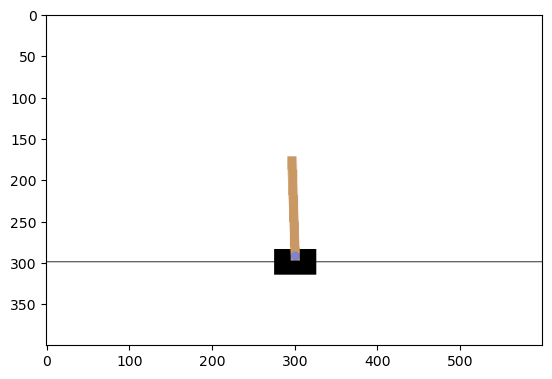

In [22]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
env = gym.make("CartPole-v0",  render_mode="rgb_array")  #if you see "<classname> has no attribute .env", remove .env or update gym

env.reset()
n_actions = env.action_space.n

# plt.imshow(env.render("rgb_array"))
# plt.show()

plt.imshow(env.render()) #rgb array

In this case use NN as a black box. All your should know that it is more complex than a tabular method. 

In [130]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit(np.array([env.reset()[0]]*n_actions),np.array([range(n_actions)] * 2));

C:\Users\vinik\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [131]:
def generate_session(t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    state = env.reset()[0]
    
    
    for t in range(t_max):
        
        #predict array of action probabilities hint: predict_proba
        
        probs = np.array(agent.predict_proba([state]))
        probs = np.reshape(probs, (-1))
        
        action = np.random.choice(np.arange(n_actions), p=probs)
        
        new_state, reward, done, _, info = env.step(action)

        done = done or _
        
        states.append(new_state)

        actions.append(action)

        total_reward += reward
        
        state = new_state
        
        if done: 
            break
    return np.array(states), np.array(actions), total_reward
        

In [132]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    rewards_batch = np.array(rewards_batch)
    
    n_session = len(states_batch)
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    ind = np.arange(n_session)
    
    ind = ind[rewards_batch[ind] >= reward_threshold]
    
    elite_states = [states_batch[i] for i in ind]
    elite_actions = [actions_batch[i] for i in ind]
    
    if(len(np.array(states_batch[0]).shape) == 1):
        elite_states = np.hstack(elite_states)
    else:
        elite_states = np.vstack(elite_states)
    elite_actions = np.hstack(elite_actions)
    
    return elite_states,elite_actions


To train this classification model use fit(states, actions). In this case we are training classificator to predict the correct class (action) in a given state

In [133]:
n_sessions = 100
percentile = 70
log = []

for i in range(1):
    #generate new sessions
    sessions = [generate_session() for _ in range(n_sessions)]
    
    states_batch, actions_batch, rewards_batch = map(list, zip(*sessions))
    
    elite_states, elite_actions = select_elites(states_batch, actions_batch, np.array(rewards_batch),percentile=50)
    
    #fit agent
    
    print(elite_states)
    print(elite_actions)
    
    new_actions = []
    
    for i in elite_actions:
        x = np.zeros(n_actions)
        x[i] = 1
        new_actions.append(x)
        
    new_actions = np.array(new_actions)
    
    agent.fit(elite_states, new_actions) # need to push smth

#     show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])
    
    if np.mean(rewards_batch)> 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

ValueError: probabilities do not sum to 1

# Report (1 pts)

In [ ]:
# Describe what you did here.  Preferably with plot/report to support it